# Imports and setup

In [2]:
# import here

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#TODO: fix yaml to include torch, correct python version

# Load in data
of form:
"Time","V1","V2","V3","V4", <br>
"V5","V6","V7","V8","V9", <br>
"V10","V11","V12","V13","V14", <br>
"V15","V16","V17","V18","V19", <br>
"V20","V21","V22","V23","V24", <br>
"V25","V26","V27","V28","Amount","Class"

Where time = seconds since first transaction <br>
V1-V28 = PCA features <br>
Amount = Size of transaction <br>
Class = final classification (fraud vs not)

In [3]:
# load it in
credit_card_data = pd.read_csv("creditcard.csv")

print(credit_card_data.head(5))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Get dataset stats (class balance, feature dist, etc)

=== Summary Statistics ===
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247

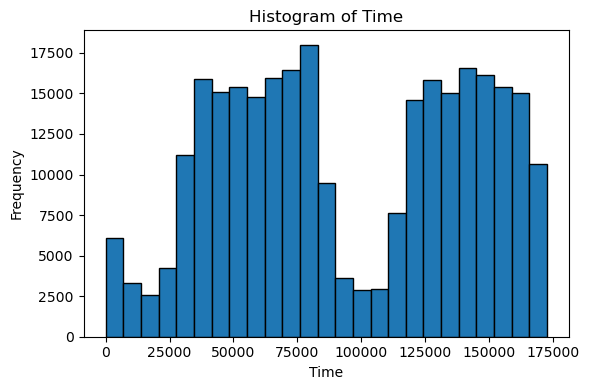

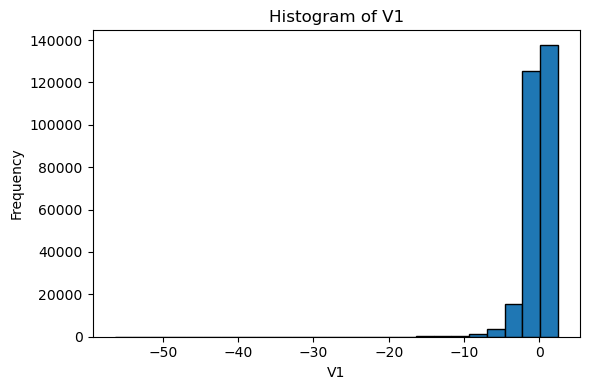

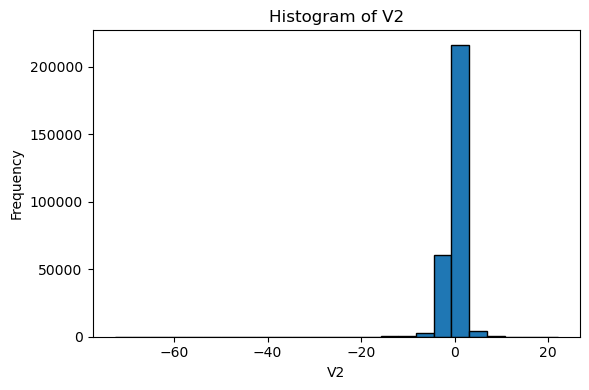

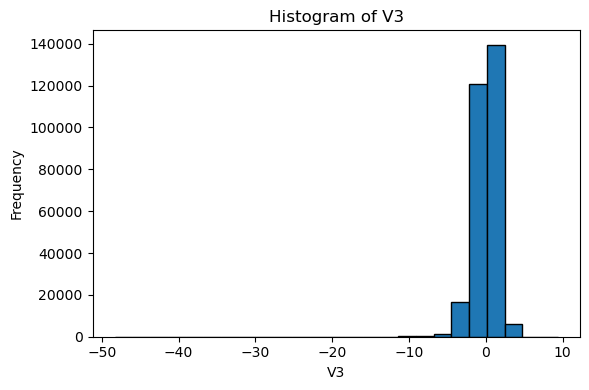

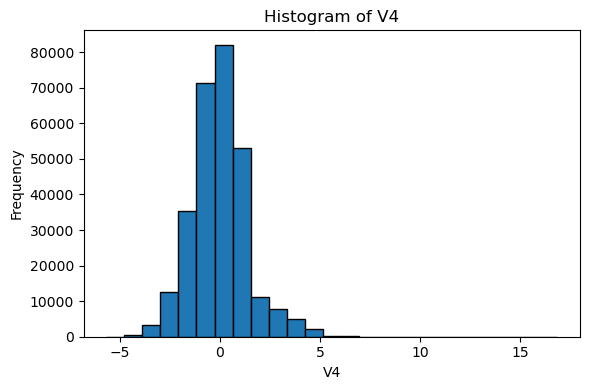

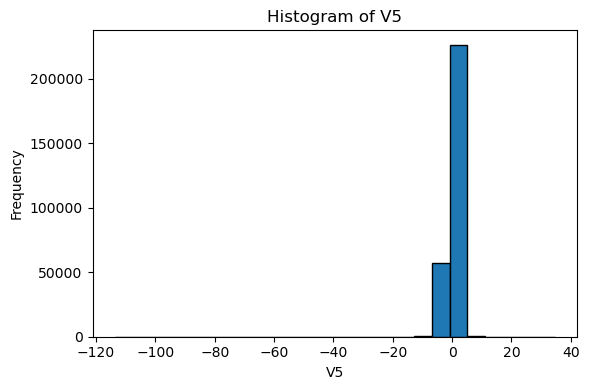

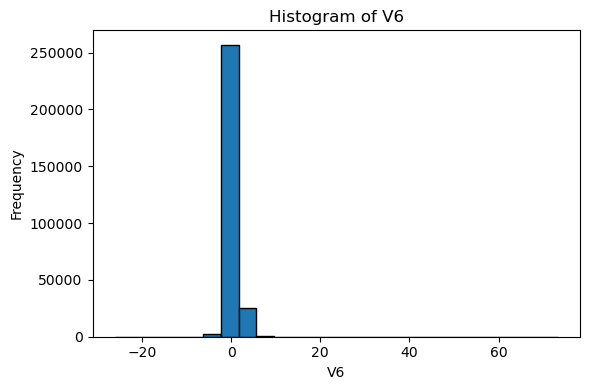

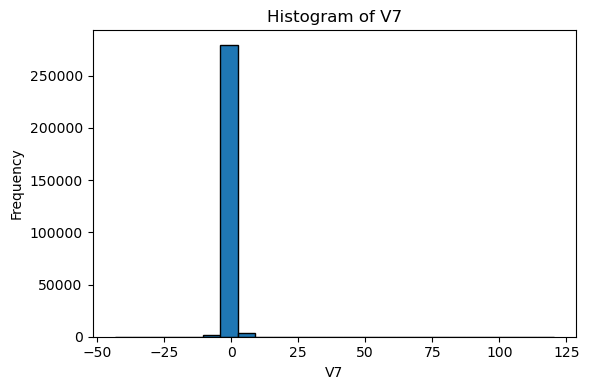

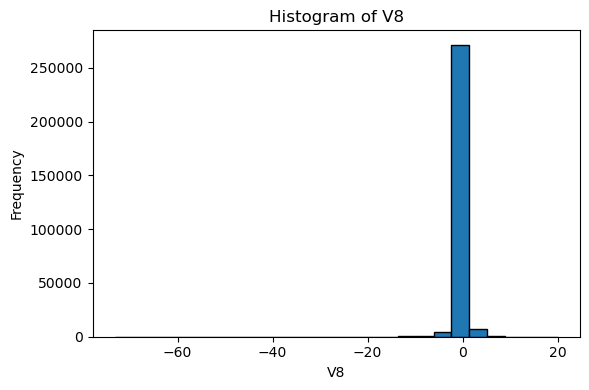

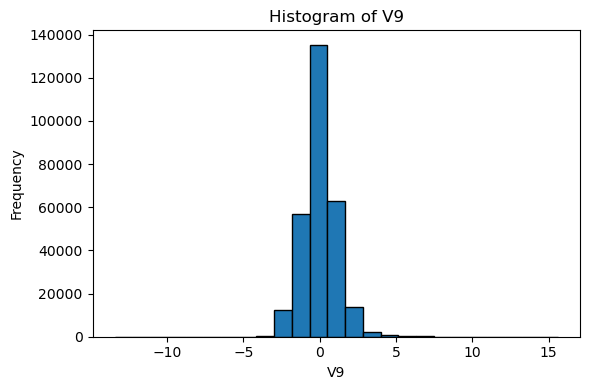

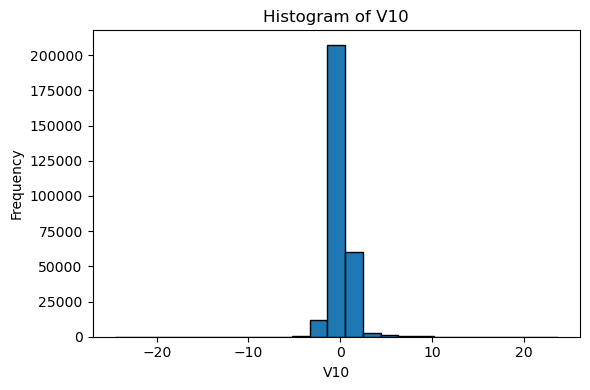

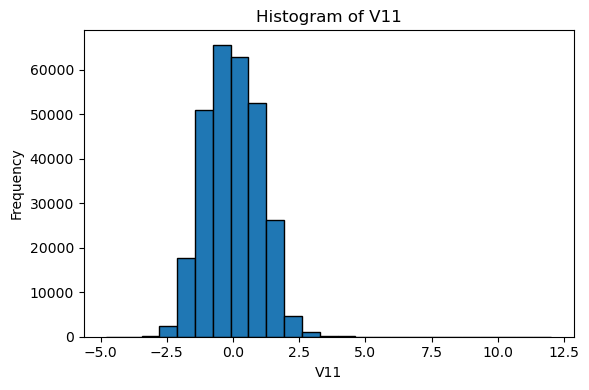

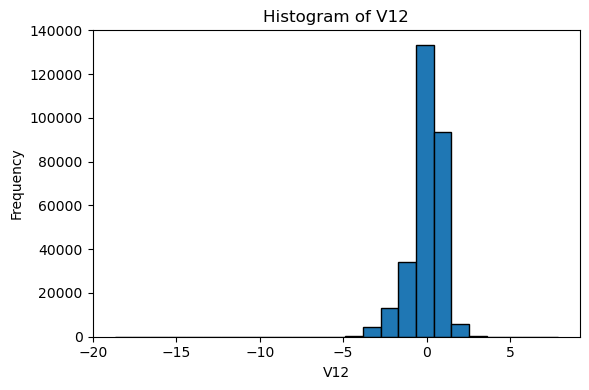

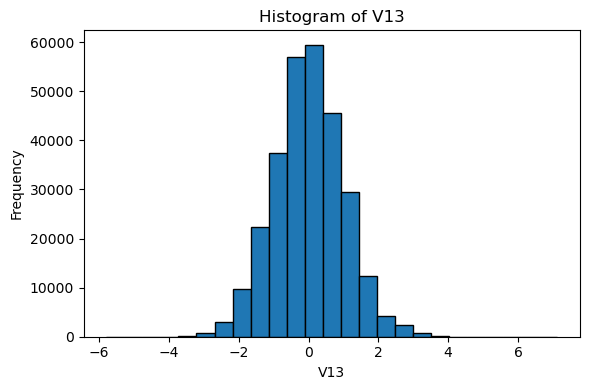

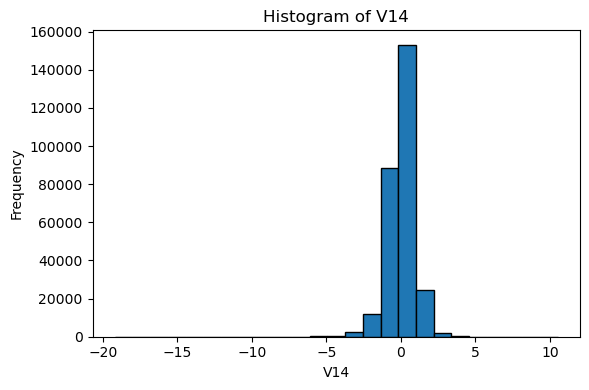

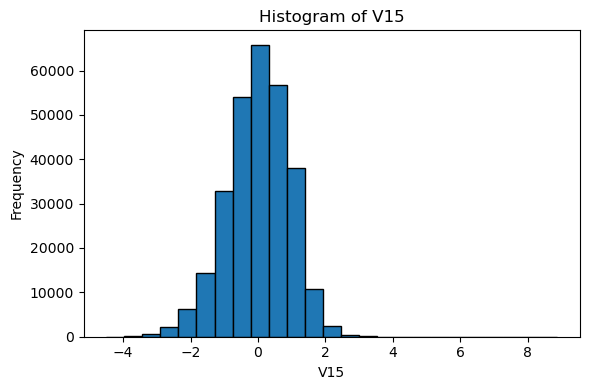

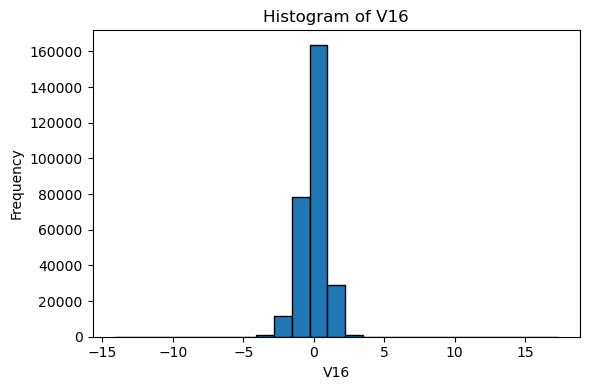

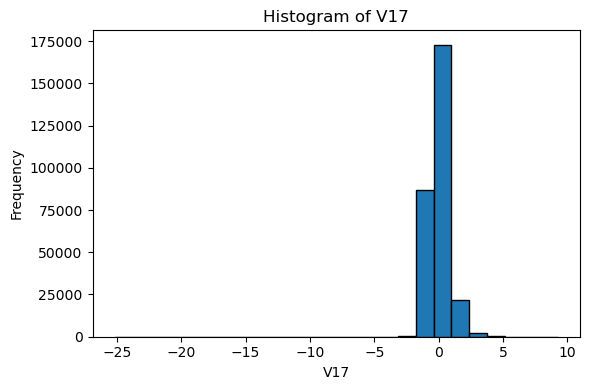

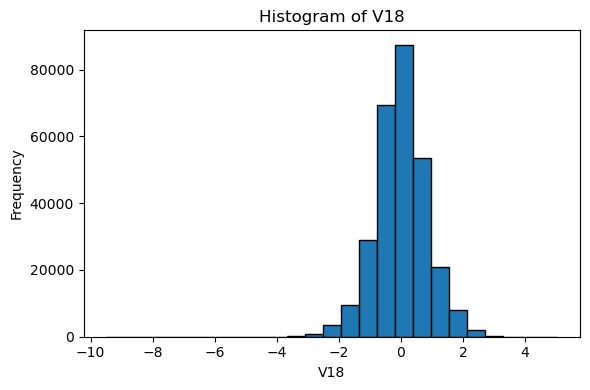

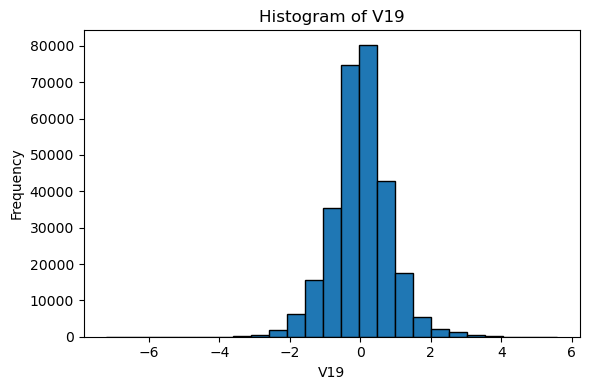

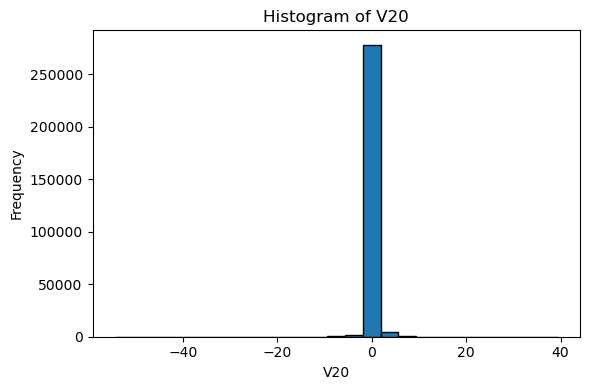

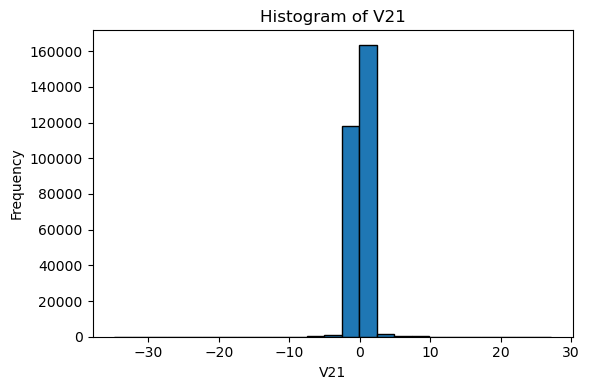

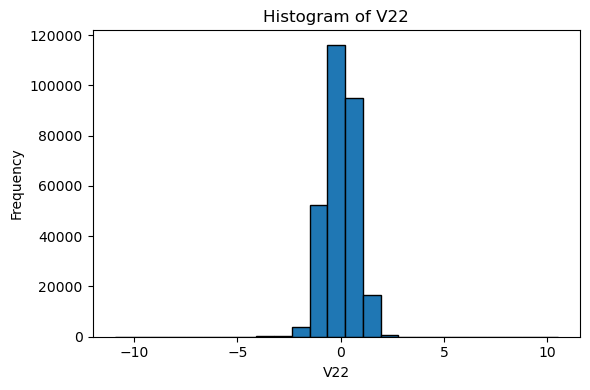

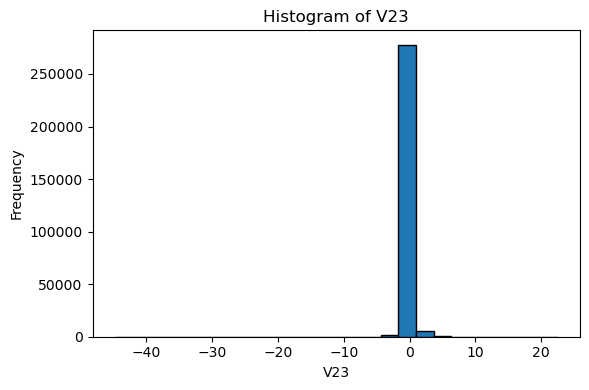

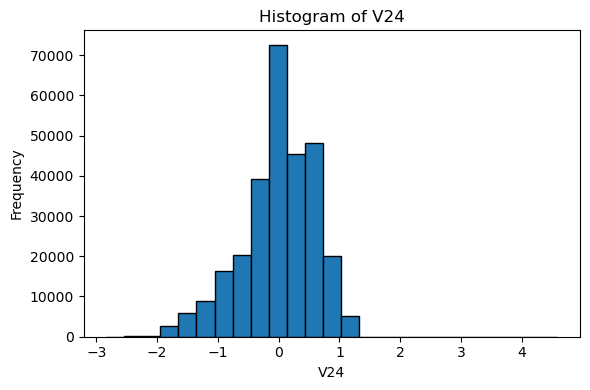

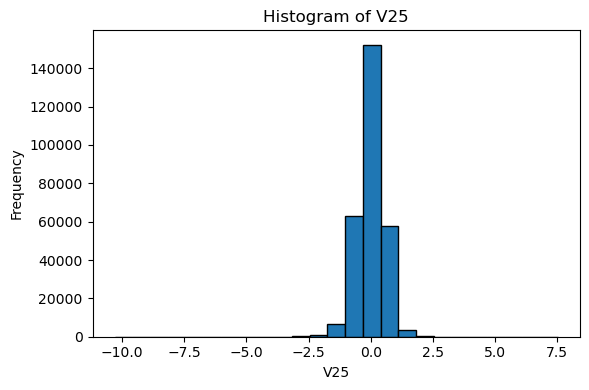

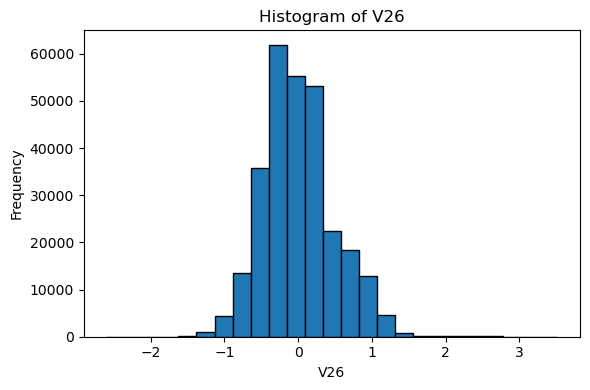

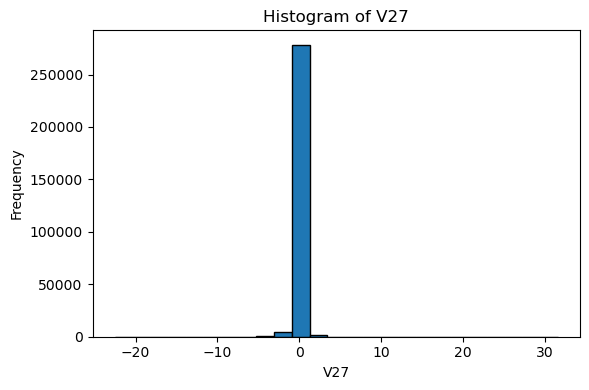

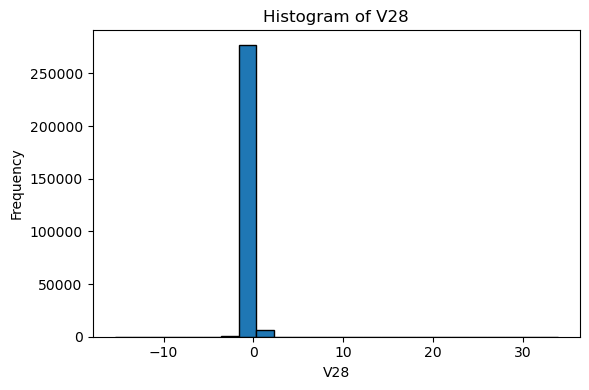

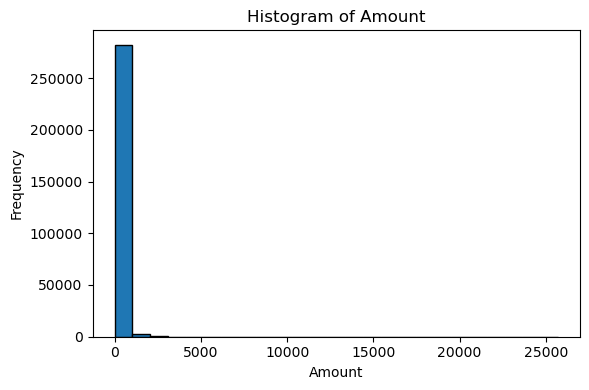


=== Class Distribution ===
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (percent):
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [4]:
# dataset stats
# --- Summary statistics ---
print("=== Summary Statistics ===")
print(credit_card_data.describe())

# --- Plot each feature (excluding 'Class') separately ---
for col in credit_card_data.columns:
    if col.lower() != 'class':
        plt.figure(figsize=(6, 4))
        plt.hist(credit_card_data[col], bins=25, edgecolor='black')
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# --- Class distribution stats ---
print("\n=== Class Distribution ===")
print(credit_card_data['Class'].value_counts())
print("\nClass distribution (percent):")
print(credit_card_data['Class'].value_counts(normalize=True) * 100)

# Check for simple linear correlations 

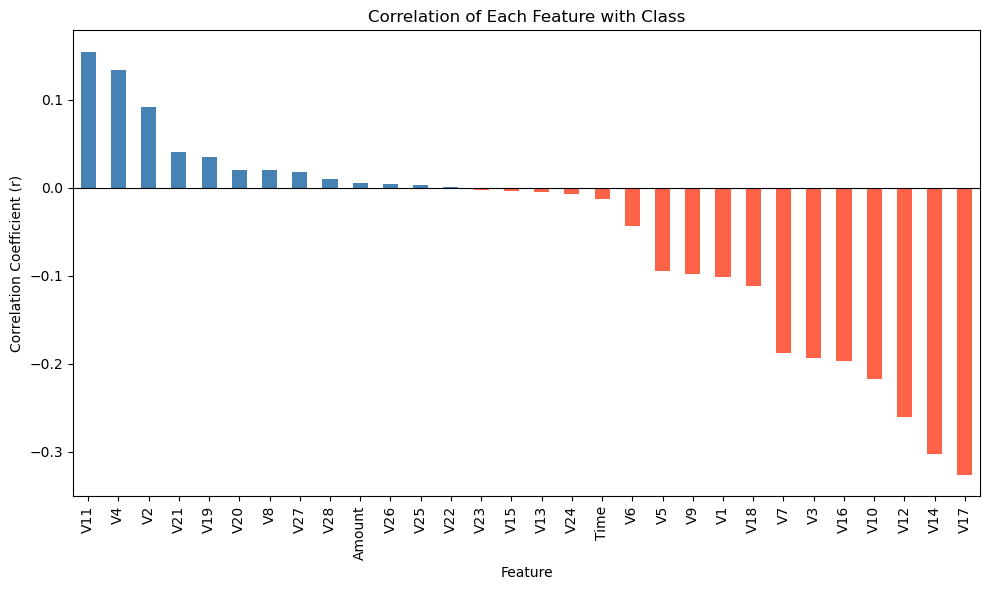

In [5]:
# make linear correlation plot

# Compute correlation matrix
corr = credit_card_data.corr(numeric_only=True)

# Get correlations with 'Class' (drop the self-correlation)
corr_with_class = corr['Class'].drop('Class').sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
corr_with_class.plot(kind='bar', color=['steelblue' if c > 0 else 'tomato' for c in corr_with_class])

plt.title("Correlation of Each Feature with Class")
plt.xlabel("Feature")
plt.ylabel("Correlation Coefficient (r)")
plt.axhline(0, color='black', linewidth=0.8)  # zero reference line
plt.tight_layout()
plt.show()

# Split data into train val test (70 20 10)

In [6]:
# stratified split (class 0 and 1)
# Separate features and target
X = credit_card_data.drop('Class', axis=1)
y = credit_card_data['Class']

# --- Step 1: Split into 70% train, 30% temp (stratified on Class)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- Step 2: Split temp into 20% val and 10% test (relative to total)
# 20% of total is 2/3 of the remaining 30%, so test_size = 1/3 for this split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(1/3), stratify=y_temp, random_state=42
)

# Confirm shapes
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Check class distribution consistency
print("\nClass balance check:")
for name, subset in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(f"{name}:")
    print(subset.value_counts(normalize=True))

Train shape: (199364, 30) (199364,)
Validation shape: (56962, 30) (56962,)
Test shape: (28481, 30) (28481,)

Class balance check:
Train:
Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64
Val:
Class
0    0.998262
1    0.001738
Name: proportion, dtype: float64
Test:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


# Make basic models -> logistic reg and compare to others such as xgboost

=== TRAIN PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    199020
           1       0.07      0.94      0.13       344

    accuracy                           0.98    199364
   macro avg       0.53      0.96      0.56    199364
weighted avg       1.00      0.98      0.99    199364


=== VALIDATION PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.86      0.12        99

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



c:\Users\jacks\Desktop\Projects\CreditCardFraudDetection\fraud_detection_ENV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


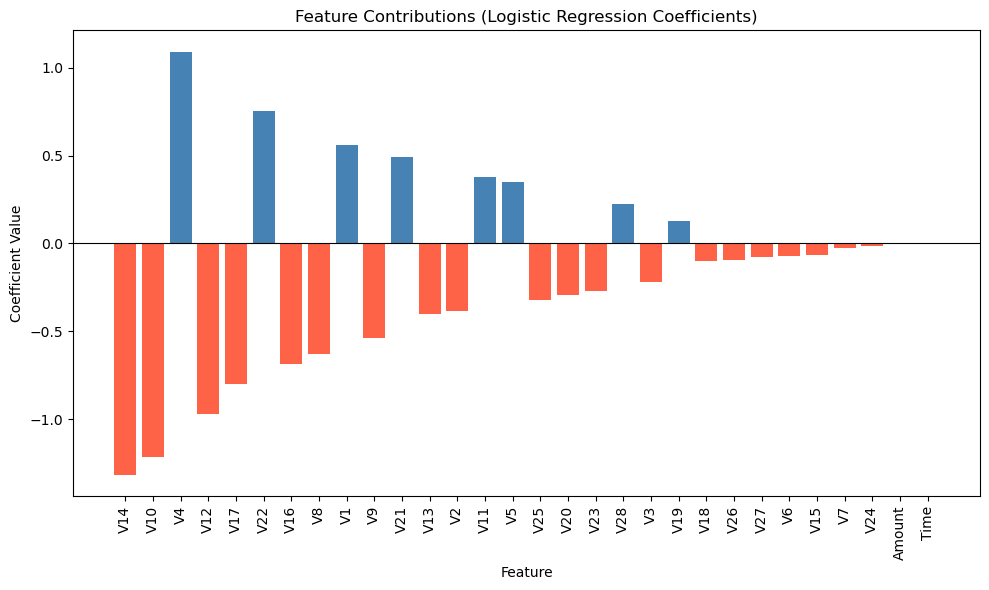

In [7]:
# logistic reg w feature plots


# --- Train logistic regression ---
# balanced makes equal weighting of classes
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')  # lbfgs handles large datasets well
log_reg.fit(X_train, y_train)

# --- Predictions ---
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

# --- Evaluation ---
print("=== TRAIN PERFORMANCE ===")
print(classification_report(y_train, y_train_pred))
print("\n=== VALIDATION PERFORMANCE ===")
print(classification_report(y_val, y_val_pred))

# --- Feature contribution plot ---
coefficients = log_reg.coef_[0]
feature_names = X_train.columns

# Sort by absolute strength for clarity
sorted_idx = np.argsort(np.abs(coefficients))[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[sorted_idx], 
        color=['steelblue' if c > 0 else 'tomato' for c in coefficients[sorted_idx]])
plt.xticks(range(len(coefficients)), feature_names[sorted_idx], rotation=90)
plt.title("Feature Contributions (Logistic Regression Coefficients)")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


# current version overidentifies positives, low precision


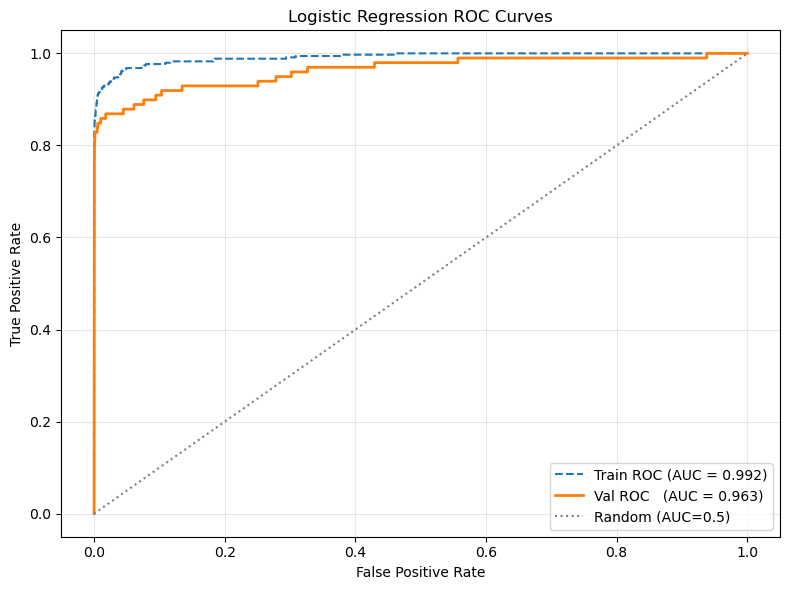

In [8]:
# AUCROC PLOT LOGREG

# build logistic pipeline with balanced class weight and scaling
log_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=42)
)

# fit on train only
log_pipeline.fit(X_train, y_train)

# get predicted probabilities for class 1
y_train_proba_log = log_pipeline.predict_proba(X_train)[:, 1]
y_val_proba_log = log_pipeline.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_log)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba_log)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {roc_auc_train:.3f})", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC   (AUC = {roc_auc_val:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

scale_pos_weight: 578.546511627907


c:\Users\jacks\Desktop\Projects\CreditCardFraudDetection\fraud_detection_ENV\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:05:52] WARNING: D:\bld\xgboost-split_1762060105351\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost TRAIN PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00       344

    accuracy                           1.00    199364
   macro avg       1.00      1.00      1.00    199364
weighted avg       1.00      1.00      1.00    199364

=== XGBoost VALIDATION PERFORMANCE ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.78      0.83        99

    accuracy                           1.00     56962
   macro avg       0.94      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



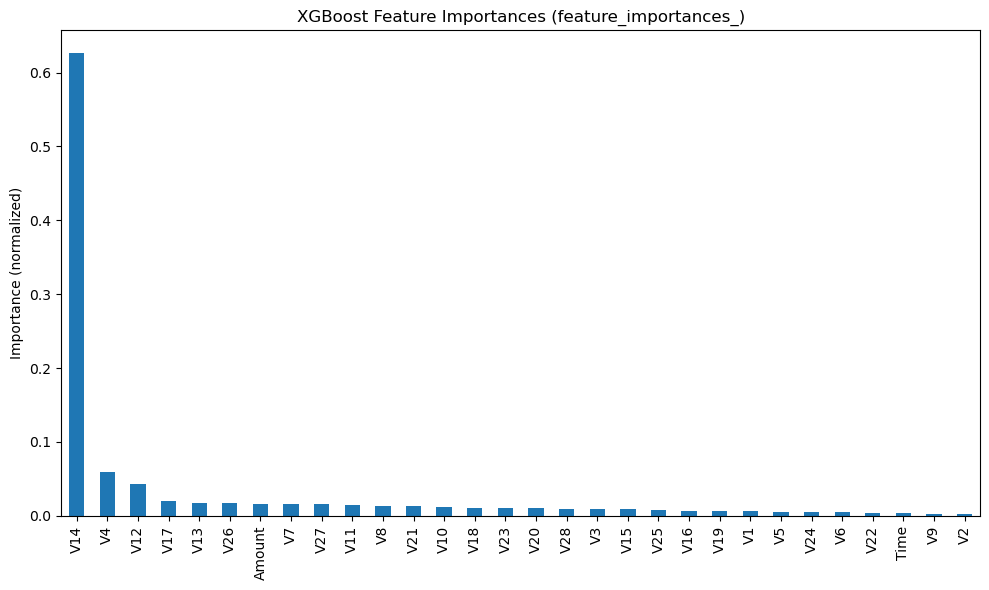

In [9]:
# xgboost w feature plots????
# compute scale_pos_weight from training set (neg/pos)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

# instantiate and train
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# predictions
y_train_pred_xgb = xgb.predict(X_train)
y_val_pred_xgb = xgb.predict(X_val)

# reports
print("=== XGBoost TRAIN PERFORMANCE ===")
print(classification_report(y_train, y_train_pred_xgb))
print("=== XGBoost VALIDATION PERFORMANCE ===")
print(classification_report(y_val, y_val_pred_xgb))

# Feature importance (sklearn wrapper .feature_importances_)
fi = xgb.feature_importances_
features = X_train.columns
fi_series = pd.Series(fi, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
fi_series.plot(kind='bar')
plt.title("XGBoost Feature Importances (feature_importances_)")
plt.ylabel("Importance (normalized)")
plt.tight_layout()
plt.show()

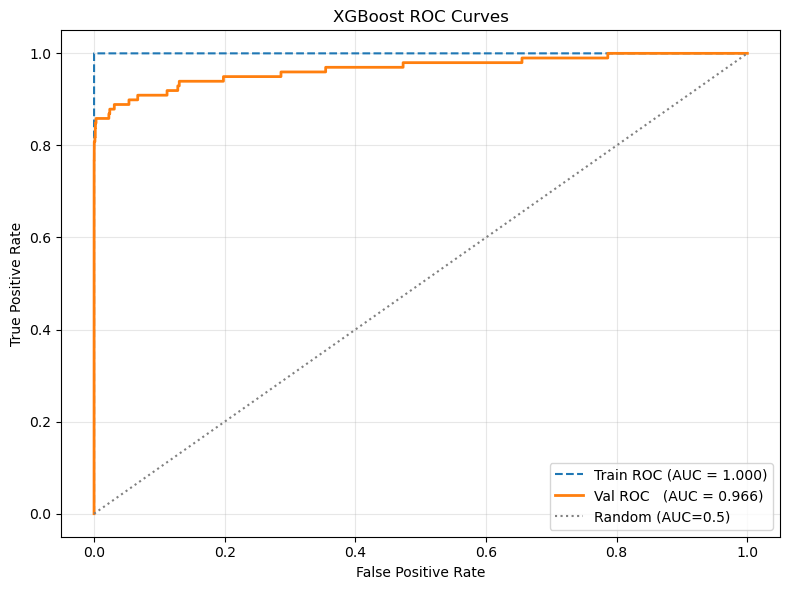

In [10]:
#AUCROC PLOT XGBOOST
# predicted probabilities for class 1
y_train_proba_xgb = xgb.predict_proba(X_train)[:, 1]
y_val_proba_xgb = xgb.predict_proba(X_val)[:, 1]

# compute ROC and AUC
fpr_train_x, tpr_train_x, _ = roc_curve(y_train, y_train_proba_xgb)
roc_auc_train_x = auc(fpr_train_x, tpr_train_x)

fpr_val_x, tpr_val_x, _ = roc_curve(y_val, y_val_proba_xgb)
roc_auc_val_x = auc(fpr_val_x, tpr_val_x)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_x, tpr_train_x, label=f"Train ROC (AUC = {roc_auc_train_x:.3f})", linestyle='--')
plt.plot(fpr_val_x, tpr_val_x, label=f"Val ROC   (AUC = {roc_auc_val_x:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature optimization (data augmentation w synthetic data)

Key metrics before: <br>
XGBoost: Val AUCROC = 0.966; Prec (0, 1): 1, 0.06; Rec (0, 1): 0.98, 0.86 <br>
LogReg: Val AUCROC = 0.963;  Prec (0, 1): 1, 0.89; Rec (0, 1): 1, 0.78


In [11]:
# add augmentation to training data and retrain both 
#   (just augment positives by adding 1% noise to a random # of vals (up to half))



def simple_augment(X_train, y_train, magnitude=0.01, random_state=42):
    """
    Simple augmentation:
      - For each positive (y==1) row in X_train, create one augmented row.
      - For that augmented row select between 1 and floor(n_features/2) columns at random.
      - For each selected column, add a random perturbation in [-0.01, +0.01] * (col_range).
    Returns:
      simple_augged_train_x (DataFrame), simple_augged_train_y (Series)
    """
    rng = np.random.default_rng(random_state)

    # Ensure X_train is a DataFrame and y_train is a Series
    X = X_train.reset_index(drop=True).copy()
    y = y_train.reset_index(drop=True).copy()

    # Indexes of positive examples
    pos_mask = (y == 1)
    pos_indices = np.flatnonzero(pos_mask)
    if len(pos_indices) == 0:
        # Nothing to augment
        print("No positive rows found in y_train. Returning originals.")
        return X.copy(), y.copy()

    n_features = X.shape[1]
    max_select = max(1, n_features // 2)   # up to half of the features, at least 1

    # Precompute column ranges (use training set ranges)
    col_max = X.max(numeric_only=True)
    col_min = X.min(numeric_only=True)
    col_range = col_max - col_min

    augmented_rows = []
    for i in pos_indices:
        row = X.loc[i].copy()   # series
        # choose how many cols to perturb: uniform random in [1, max_select]
        k = int(rng.integers(1, max_select + 1))
        # pick k distinct columns
        cols = rng.choice(X.columns, size=k, replace=False)

        for col in cols:
            # If range is zero or non-numeric, skip perturbation
            r = col_range.get(col, 0)
            if pd.isnull(r) or r == 0:
                continue
            # perturbation: random in [-0.01, +0.01] times the range
            frac = rng.uniform(-1 * magnitude, magnitude)
            delta = frac * r
            row[col] = row[col] + delta

        augmented_rows.append(row)

    # Build augmented DataFrame and labels
    aug_df = pd.DataFrame(augmented_rows).reset_index(drop=True)
    aug_labels = pd.Series([1] * len(aug_df), name=y.name)

    # Concatenate to form final train set
    simple_augged_train_x = pd.concat([X, aug_df], ignore_index=True)
    simple_augged_train_y = pd.concat([y, aug_labels], ignore_index=True)

    # Optional: preserve dtypes for numeric columns
    for col in X.columns:
        try:
            simple_augged_train_x[col] = simple_augged_train_x[col].astype(X[col].dtype)
        except Exception:
            # skip if can't cast (safe fallback)
            pass

    print(f"Original train size: {X.shape[0]} rows")
    print(f"Augmented rows added: {len(aug_df)}")
    print(f"New train size: {simple_augged_train_x.shape[0]} rows")

    return simple_augged_train_x, simple_augged_train_y

# Run augmentation (use your X_train, y_train)
X_train_aug, y_train_aug = simple_augment(X_train, y_train, magnitude=0.0075, random_state=42)

# Quick sanity checks
print("\nLabel counts before augmentation:")
print(y_train.value_counts())
print("\nLabel counts after augmentation:")
print(y_train_aug.value_counts())


Original train size: 199364 rows
Augmented rows added: 344
New train size: 199708 rows

Label counts before augmentation:
Class
0    199020
1       344
Name: count, dtype: int64

Label counts after augmentation:
Class
0    199020
1       688
Name: count, dtype: int64


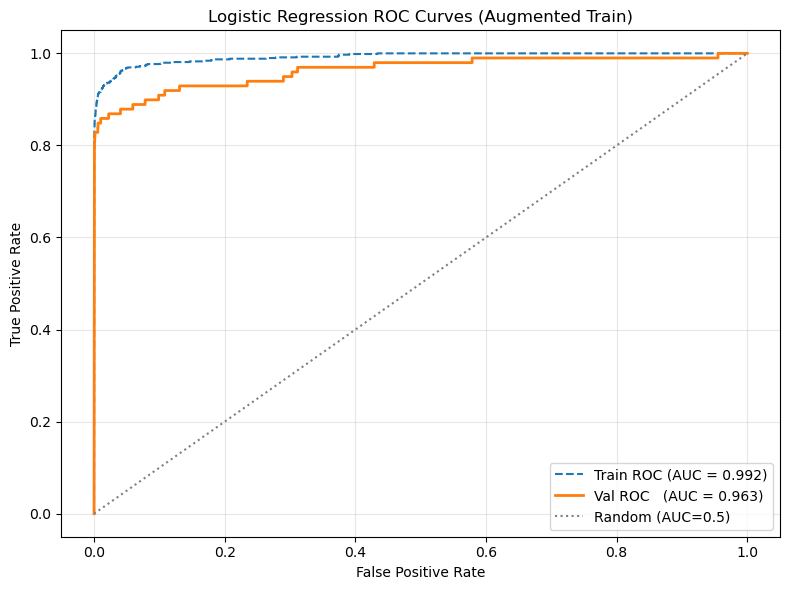

In [12]:
# test on logreg
# Build pipeline (scaling + logistic with balanced class weights)
log_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=42)
)

# Fit on augmented train
log_pipeline.fit(X_train_aug, y_train_aug)

# Probabilities for class 1
y_train_proba = log_pipeline.predict_proba(X_train_aug)[:, 1]
y_val_proba = log_pipeline.predict_proba(X_val)[:, 1]

# ROC & AUC
fpr_train, tpr_train, _ = roc_curve(y_train_aug, y_train_proba)
train_auc = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
val_auc = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC   (AUC = {val_auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves (Augmented Train)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

metrics = {"train_auc": train_auc, "val_auc": val_auc}



XGB scale_pos_weight computed from augmented train: 289.2732558139535


c:\Users\jacks\Desktop\Projects\CreditCardFraudDetection\fraud_detection_ENV\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:05:54] WARNING: D:\bld\xgboost-split_1762060105351\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


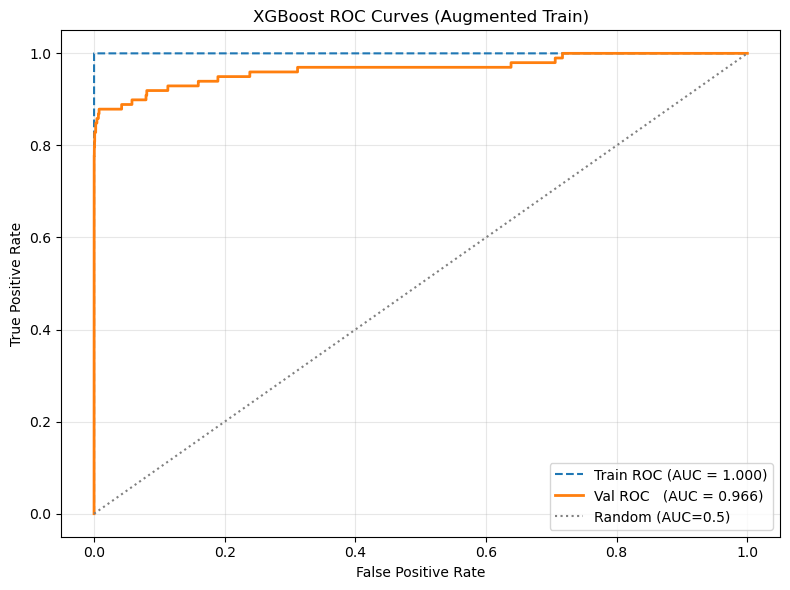

In [13]:
# test on xgboost
# compute scale_pos_weight from augmented train set
neg = int((y_train_aug == 0).sum())
pos = int((y_train_aug == 1).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print("XGB scale_pos_weight computed from augmented train:", scale_pos_weight)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

# Fit on augmented train
xgb.fit(X_train_aug, y_train_aug)

# Probabilities for class 1
y_train_proba = xgb.predict_proba(X_train_aug)[:, 1]
y_val_proba = xgb.predict_proba(X_val)[:, 1]

# ROC & AUC
fpr_train, tpr_train, _ = roc_curve(y_train_aug, y_train_proba)
train_auc = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
val_auc = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC   (AUC = {val_auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves (Augmented Train)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

metrics = {"train_auc": train_auc, "val_auc": val_auc}

# Simple aug did not seem to be very effective, trying w VAE

In [14]:
# aug w VAE (also only add to positive class)


# train VAE, add sythetic data
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5, hidden_dims=(128, 64), conditional_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.conditional_dim = conditional_dim
        enc_in = input_dim + conditional_dim
        # Encoder
        enc_layers = []
        last = enc_in
        for h in hidden_dims:
            enc_layers.append(nn.Linear(last, h))
            enc_layers.append(nn.ReLU())
            last = h
        self.encoder_net = nn.Sequential(*enc_layers)
        self.fc_mu = nn.Linear(last, latent_dim)
        self.fc_logvar = nn.Linear(last, latent_dim)

        # Decoder
        dec_in = latent_dim + conditional_dim
        dec_layers = []
        last = dec_in
        for h in reversed(hidden_dims):
            dec_layers.append(nn.Linear(last, h))
            dec_layers.append(nn.ReLU())
            last = h
        dec_layers.append(nn.Linear(last, input_dim))  # reconstruct only features
        self.decoder_net = nn.Sequential(*dec_layers)

    def encode(self, x, y):
        # x: (batch, input_dim), y: (batch, conditional_dim)
        xy = torch.cat([x, y], dim=1)
        h = self.encoder_net(xy)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        recon = self.decoder_net(zy)
        return recon

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar

def train_cvae(
    X, y,
    latent_dim=5,
    epochs=50,
    batch_size=256,
    lr=1e-3,
    weight_kl=1.0,
    device=None,
    verbose=True,
    random_state=42
):
    """
    Train a conditional VAE on numeric DataFrame X and Series y (binary 0/1).
    Returns: trained_model, scaler
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure inputs are DataFrame/Series
    X_df = X.copy().reset_index(drop=True)
    y_s = y.copy().reset_index(drop=True)

    # Standardize features (fit on X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df.values.astype(np.float32))

    # Prepare tensors
    X_tensor = torch.from_numpy(X_scaled).float()
    y_tensor = torch.from_numpy(y_s.values.astype(np.float32)).unsqueeze(1)  # shape (N,1)
    # Move to device later via DataLoader batches

    # Compute class weights (inverse frequency) to weight reconstruction loss
    classes, counts = np.unique(y_s.values, return_counts=True)
    freq = dict(zip(classes, counts))
    # avoid zero division
    total = len(y_s)
    class_weights = {int(c): total / (len(classes) * max(1, freq[int(c)])) for c in classes}
    # map to tensor per sample
    sample_weights_np = np.array([class_weights[int(v)] for v in y_s.values], dtype=np.float32)
    sample_weights_tensor = torch.from_numpy(sample_weights_np).float()

    # DataLoader
    dataset = TensorDataset(X_tensor, y_tensor, sample_weights_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    input_dim = X_tensor.shape[1]
    model = ConditionalVAE(input_dim=input_dim, latent_dim=latent_dim, conditional_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    mse_loss = nn.MSELoss(reduction='none')  # we want per-element losses
    rng = np.random.default_rng(random_state)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        epoch_recon = 0.0
        epoch_kld = 0.0
        n = 0
        for xb, yb, swb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            swb = swb.to(device)

            optimizer.zero_grad()
            recon, mu, logvar = model(xb, yb)
            # reconstruction loss per sample (sum over features)
            per_elem = mse_loss(recon, xb)  # shape (batch, input_dim)
            per_sample_recon = per_elem.sum(dim=1)  # sum over features -> (batch,)
            # apply sample weights (class weighting)
            weighted_recon = per_sample_recon * swb
            recon_loss = weighted_recon.mean()

            # KLD per sample
            kld_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
            kld_loss = kld_per_sample.mean()

            loss = recon_loss + weight_kl * kld_loss
            loss.backward()
            optimizer.step()

            batch_n = xb.size(0)
            epoch_loss += loss.item() * batch_n
            epoch_recon += recon_loss.item() * batch_n
            epoch_kld += kld_loss.item() * batch_n
            n += batch_n

        epoch_loss /= n
        epoch_recon /= n
        epoch_kld /= n
        if verbose and (epoch % max(1, epochs // 10) == 0 or epoch == 1 or epoch == epochs):
            print(f"Epoch {epoch:3d}/{epochs}  total_loss={epoch_loss:.6f}  recon={epoch_recon:.6f}  kld={epoch_kld:.6f}")

    # Put model in eval mode
    model.eval()
    return {"model": model, "scaler": scaler, "class_weights": class_weights, "device": device}

# call train func

# assume original numeric DataFrame X_all and Series y_all (Class) exist
# e.g., X_all = credit_card_data.drop('Class', axis=1); y_all = credit_card_data['Class']

res = train_cvae(X_train, y_train, latent_dim=5, epochs=60, batch_size=512, lr=1e-3, weight_kl=1.0, verbose=True)
model_info = res  # contains model, scaler, device, class_weights

#TODO: move func calls to correct spot, push changes to git
# also install  conda install pytorch torchvision torchaudio pytorch-cuda=12.6 -c pytorch -c nvidia


Epoch   1/60  total_loss=231.890333  recon=230.923977  kld=0.966357
Epoch   6/60  total_loss=42.082810  recon=40.901173  kld=1.181637
Epoch  12/60  total_loss=41.579572  recon=40.457966  kld=1.121606
Epoch  18/60  total_loss=31.839050  recon=30.827373  kld=1.011678
Epoch  24/60  total_loss=29.922049  recon=28.635754  kld=1.286295
Epoch  30/60  total_loss=28.541496  recon=27.162337  kld=1.379159
Epoch  36/60  total_loss=31.059358  recon=29.543315  kld=1.516043
Epoch  42/60  total_loss=24.674753  recon=23.151343  kld=1.523410
Epoch  48/60  total_loss=27.282097  recon=25.723017  kld=1.559080
Epoch  54/60  total_loss=20.652720  recon=19.091356  kld=1.561364
Epoch  60/60  total_loss=24.515114  recon=22.918005  kld=1.597109


In [15]:
# add data

def generate_from_cvae(cvae_dict, n0=0, n1=0, latent_dim=5, X_columns=None, random_state=42, clip_to_observed=True):
    """
    Generate n0 negative (class 0) and n1 positive (class 1) samples using a trained CVAE.
    Inputs:
      - cvae_dict: dict returned from train_cvae (contains 'model', 'scaler', 'device')
      - n0, n1: number of samples to generate for class 0 and class 1
      - latent_dim: latent dimension used when training (must match)
      - X_columns: list-like of original column names (if None, numeric column names will be generated)
      - clip_to_observed: if True, clip generated values to the min/max observed by scaler inverse transform
    Returns:
      - (df_synth, y_synth) where df_synth is DataFrame of shape (n0+n1, n_features) and y_synth is Series of labels
    """
    model = cvae_dict["model"]
    scaler = cvae_dict["scaler"]
    device = cvae_dict["device"]
    model.to(device)
    model.eval()

    rng = np.random.default_rng(random_state)

    def _gen_for_class(n, cls_val):
        if n <= 0:
            return np.empty((0, scaler.mean_.shape[0]), dtype=float), np.empty((0,), dtype=int)
        # sample z ~ N(0, I)
        z = np.random.normal(size=(n, latent_dim)).astype(np.float32)
        z_t = torch.from_numpy(z).to(device)
        # class conditioning as column of shape (n,1)
        y_cond = torch.full((n, 1), float(cls_val), dtype=torch.float32).to(device)
        # decode directly using model.decode (no encode step)
        with torch.no_grad():
            x_recon_t = model.decode(z_t, y_cond)
        x_recon = x_recon_t.cpu().numpy()
        # inverse scale
        x_orig = scaler.inverse_transform(x_recon)
        if clip_to_observed:
            # clip each feature to observed min/max used by scaler (approximate with mean +/- 5*std if min/max not stored)
            # best-effort: we can compute observed min/max from scaler if available: scaler.scale_/mean_ exist
            # we will not strictly clamp to training min/max (scaler doesn't keep minmax) so do a soft clip using mean +/- 10*scale
            means = scaler.mean_
            scales = scaler.scale_
            lower = means - 10 * scales
            upper = means + 10 * scales
            x_orig = np.minimum(np.maximum(x_orig, lower), upper)
        y_arr = np.full((n,), int(cls_val), dtype=int)
        return x_orig, y_arr

    x0, y0 = _gen_for_class(n0, 0)
    x1, y1 = _gen_for_class(n1, 1)

    if X_columns is None:
        X_columns = [f"f{i}" for i in range(x0.shape[1] if x0.shape[1] else x1.shape[1])]

    X_all = np.vstack([x0, x1]) if (x0.size and x1.size) else (x0 if x1.size==0 else x1)
    y_all = np.concatenate([y0, y1]) if (y0.size and y1.size) else (y0 if y1.size==0 else y1)

    df = pd.DataFrame(X_all, columns=X_columns)
    y_series = pd.Series(y_all, name="Class")

    # if no samples requested, return empty DataFrame/Series consistent with columns
    if df.shape[0] == 0:
        df = pd.DataFrame(columns=X_columns)
        y_series = pd.Series(dtype=int, name="Class")

    return df, y_series

# Generate 1000 negatives and 200 positives for augmentation
synth_X, synth_y = generate_from_cvae(model_info, n0=1000, n1=200, latent_dim=5, X_columns=X_train.columns, random_state=123)

# Quick checks
print("Synthetic shape:", synth_X.shape)
print("Synthetic class counts:", synth_y.value_counts())
print(synth_X.head())


Synthetic shape: (1200, 30)
Synthetic class counts: Class
0    1000
1     200
Name: count, dtype: int64
            Time        V1        V2        V3        V4        V5        V6  \
0   89371.000000  0.627439  0.102061  0.179270 -0.150114 -0.007530 -0.115398   
1   96470.289062  0.212785 -0.120837  0.024795 -0.110593 -0.062369  0.035973   
2  111429.507812  0.639107 -0.108948 -0.118069  0.059744  0.109971  0.049890   
3  130375.578125  0.404250 -0.166352 -0.533165 -0.512352  0.079570 -0.150259   
4  131051.968750  0.519162  0.004696 -0.522411 -0.372581  0.176903 -0.128071   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0  0.057769  0.157719  0.038762  ... -0.044921 -0.025323 -0.050469  0.019623   
1 -0.023187  0.106731 -0.138442  ... -0.058995 -0.049773  0.034620  0.132086   
2  0.199223  0.099605 -0.136483  ... -0.139530 -0.006046  0.029629  0.089850   
3  0.169230  0.033268  0.139659  ... -0.058339  0.009465  0.047895 -0.086133   
4  0.131410  0.

In [18]:
# make larger dataset by joining synth and og train data
complex_aug_train_X = pd.concat([X_train, synth_X], ignore_index=True)
complex_aug_train_Y = pd.concat([y_train, synth_y], ignore_index=True)


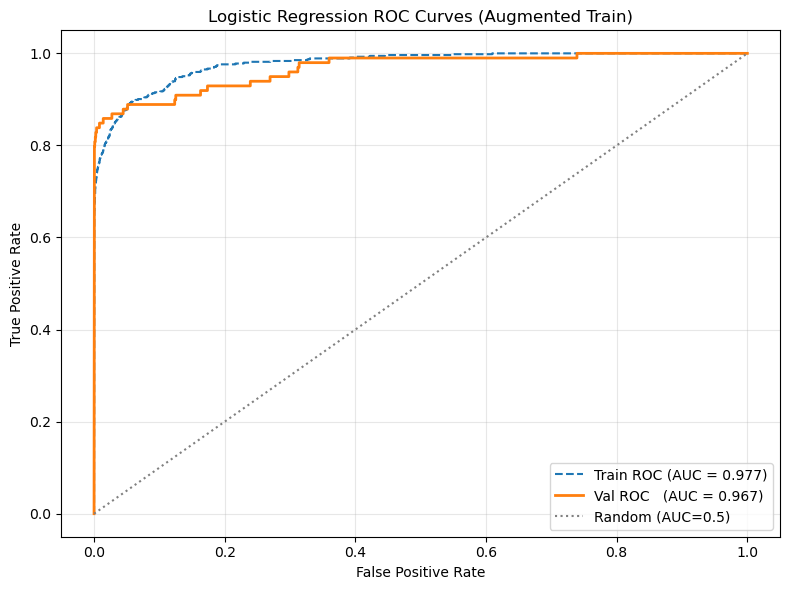

In [19]:
# test on logreg
# Build pipeline (scaling + logistic with balanced class weights)
log_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=42)
)

# Fit on augmented train
log_pipeline.fit(complex_aug_train_X, complex_aug_train_Y)

# Probabilities for class 1
y_train_proba = log_pipeline.predict_proba(complex_aug_train_X)[:, 1]
y_val_proba = log_pipeline.predict_proba(X_val)[:, 1]

# ROC & AUC
fpr_train, tpr_train, _ = roc_curve(complex_aug_train_Y, y_train_proba)
train_auc = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
val_auc = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC   (AUC = {val_auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves (Augmented Train)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

metrics = {"train_auc": train_auc, "val_auc": val_auc}



XGB scale_pos_weight computed from augmented train: 367.68382352941177


c:\Users\jacks\Desktop\Projects\CreditCardFraudDetection\fraud_detection_ENV\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:22:00] WARNING: D:\bld\xgboost-split_1762060105351\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


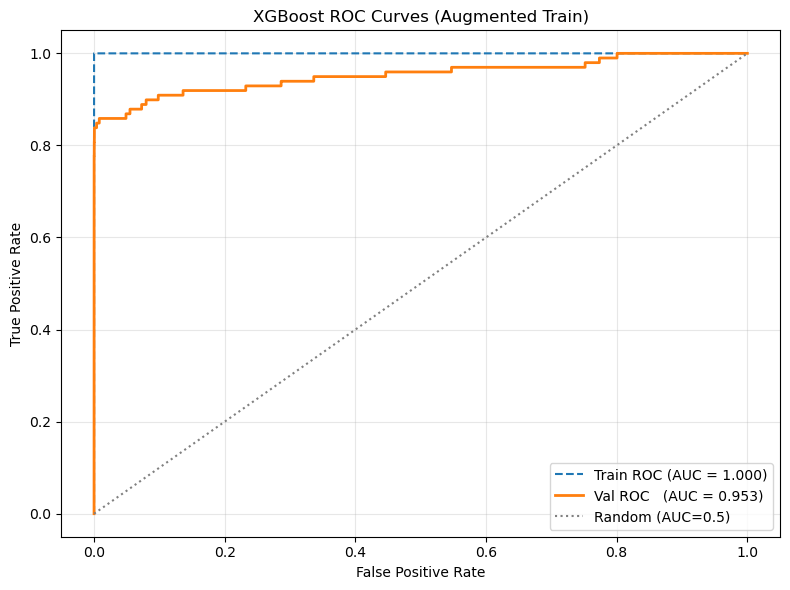

In [20]:
# test on xgboost
# compute scale_pos_weight from augmented train set
neg = int((complex_aug_train_Y == 0).sum())
pos = int((complex_aug_train_Y == 1).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print("XGB scale_pos_weight computed from augmented train:", scale_pos_weight)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

# Fit on augmented train
xgb.fit(complex_aug_train_X, complex_aug_train_Y)

# Probabilities for class 1
y_train_proba = xgb.predict_proba(complex_aug_train_X)[:, 1]
y_val_proba = xgb.predict_proba(X_val)[:, 1]

# ROC & AUC
fpr_train, tpr_train, _ = roc_curve(complex_aug_train_Y, y_train_proba)
train_auc = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
val_auc = auc(fpr_val, tpr_val)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC   (AUC = {val_auc:.3f})", linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle=':', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves (Augmented Train)")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

metrics = {"train_auc": train_auc, "val_auc": val_auc}